### DiBS joint inference of $p(G, \Theta | \mathcal{D})$ for linear/nonlinear Gaussian Bayes nets

DiBS translates the task of inferring the posterior over Bayesian networks into an inference problem over the continuous latent variable $Z$. This is achieved by modeling the directed acyclic graph $G$ of the Bayesian network using the generative model $p(G | Z)$. The prior $p(Z)$ enforces the acyclicity of $G$.
Ultimately, this allows us to infer $p(G, \Theta | \mathcal{D})$ (and $p(G | \mathcal{D})$) using off-the-shelf inference methods such as Stein Variational gradient descent (SVGD) (Liu and Wang, 2016).

In [1]:
import jax
import jax.random as random

key = random.PRNGKey(123)
print(f"JAX backend: {jax.default_backend()}")

JAX backend: cpu


### Generate synthetic ground truth Bayesian network and BN model for inference

`data` contains information about and observations sampled from a synthetic, ground truth causal model with `n_vars` variables. By default, the conditional distributions are linear Gaussian. The random graph model is set by `graph_prior_str`, where `er` denotes Erdos-Renyi and `sf` scale-free graphs. 

`model` defines prior $p(G, \Theta)$ and likelihood $p(x | G, \Theta)$ of the BN model for which DiBS will infer the posterior.

**For posterior inference of nonlinear Gaussian networks parameterized by fully-connected neural networks, use the function `make_nonlinear_gaussian_model`.** 


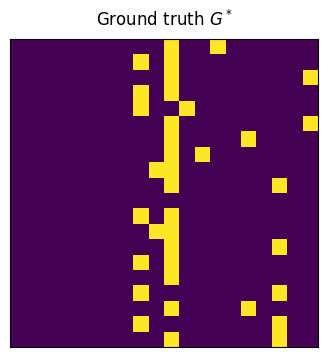

In [2]:
import sys  
sys.path.insert(0, '../')
from dibs.target import make_linear_gaussian_model, make_nonlinear_gaussian_model
from dibs.utils import visualize_ground_truth

key, subk = random.split(key)
data, model = make_nonlinear_gaussian_model(key=subk, n_vars=20, graph_prior_str="sf")

visualize_ground_truth(data.g)

### DiBS with SVGD

Infer $p(G, \Theta | D)$ under the prior and conditional distributions defined by `model`.
The below visualization shows the *matrix of edge probabilities* $G_\alpha(Z^{(k)})$ implied by each transported latent particle (i.e., sample) $Z^{(k)}$ during the iterations of SVGD with DiBS. Refer to the paper for further details.

To explicitly perform posterior inference of $p(G | \mathcal{D})$ using a closed-form marginal likelihood $p(D | G)$, use the separate, analogous class `MarginalDiBS` as demonstrated in the example notebook `dibs_marginal.ipynb`.



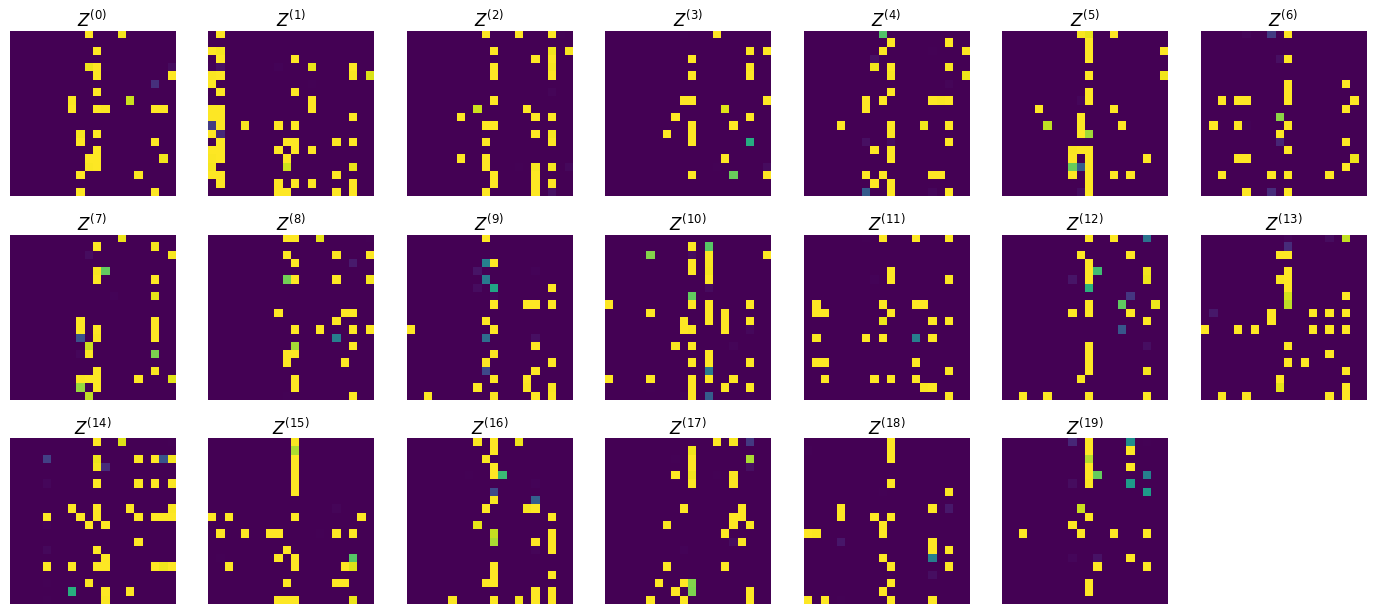

iteration   2000 | alpha  100.0 | beta 2000.0 | #cyclic  17


In [3]:
from dibs.inference import JointDiBS

dibs = JointDiBS(x=data.x, interv_mask=None, inference_model=model)
key, subk = random.split(key)
gs, thetas = dibs.sample(key=subk, n_particles=20, steps=2000, callback_every=20, callback=dibs.visualize_callback())

### Evaluate on held-out data

Form the empirical (i.e., weighted by counts) and mixture distributions (i.e., weighted by unnormalized posterior probabilities, denoted DiBS+).

In [ ]:
dibs_empirical = dibs.get_empirical(gs, thetas)
dibs_mixture = dibs.get_mixture(gs, thetas)

Compute some evaluation metrics.

In [ ]:
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:
    
    eshd = expected_shd(dist=dist, g=data.g)        
    auroc = threshold_metrics(dist=dist, g=data.g)['roc_auc']
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=dibs.eltwise_log_likelihood_observ, x=data.x_ho)
    
    print(f'{descr} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. LL {negll:5.2f}')
    